In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,BernoulliNB,ComplementNB,MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, Perceptron
from google.colab import files
from sklearn import preprocessing 
from sklearn.feature_selection import chi2,SelectKBest
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier


In [ ]:
train_fake_bow_url = "https://raw.githubusercontent.com/julia-sand/data-stuff/main/train_fake_bow.csv"
train_true_bow_url = "https://raw.githubusercontent.com/julia-sand/data-stuff/main/train_true_bow.csv"

#test data
test_url = "https://raw.githubusercontent.com/julia-sand/data-stuff/main/test_bow.csv"
test_df = pd.DataFrame(pd.read_csv(test_url, header=None, sep=","))

train_fake_df = pd.DataFrame(pd.read_csv(train_fake_bow_url, header=None, sep=","))
train_true_df = pd.DataFrame(pd.read_csv(train_true_bow_url, header=None, sep=","))

Class_fake = np.zeros(len(train_fake_df)).astype(int)
Class_true = np.ones(len(train_true_df)).astype(int)

train_fake_df["Class"] = Class_fake
train_true_df["Class"] = Class_true

train_df = train_fake_df.append(train_true_df,ignore_index=True)

X = train_df.iloc[:,:-1].values
X_unseen = test_df.values

y = train_df.Class.values
y_minus = np.where(y == 1,1,-1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.4, 
                                                    random_state=13,
                                                    stratify=y)

y_train_minus = np.where(y_train == 1,1,-1)
y_test_minus = np.where(y_test == 1,1,-1)

n_features = X.shape[1]

0.8955456570155902


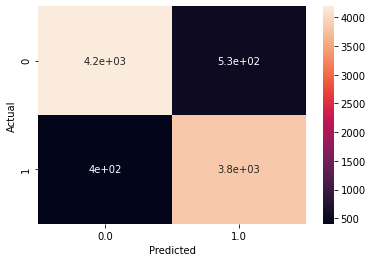

In [ ]:
#set up few models and test out ensemble method
nb = BernoulliNB()
nb.fit(X_train, y_train)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

#probabilities of class 1
proba_nb = nb.predict_proba(X_test)[:,1]
proba_logreg = logreg.predict_proba(X_test)[:,1]


proba_mean = (proba_nb + proba_logreg) / 2

#turn proba into preds
y_pred_test= np.ones(len(proba_mean))
for i in range(len(y_pred_test)):
    y_pred_test[i] = 1 if proba_mean[i] > 0.5 else 0

print(accuracy_score(y_pred_test,y_test))


confusion_matrix = pd.crosstab(y_test, y_pred_test, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)



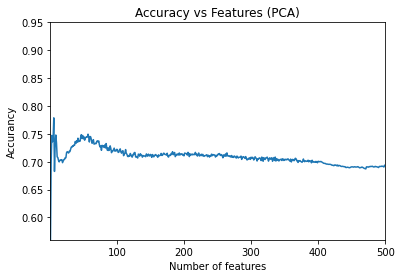

In [ ]:
acc_train = np.zeros(n_features)

for i in range(1,n_features):
    pca = PCA(n_components=i)
    X_train_i = pca.fit_transform(X_train)
    X_test_i = pca.transform(X_test)

    model = GaussianNB()
    model.fit(X_train_i, y_train)
    y_pred_i = model.predict(X_test_i)

    acc_train[i] = accuracy_score(y_pred_i,y_test)


plt.plot(acc_train)
axes = plt.gca()
axes.set_ylim([0.56,0.95])
axes.set_xlim([1,n_features])
plt.xlabel('Number of features',fontsize=10)
plt.ylabel('Accurancy')
plt.title("Accuracy vs Features (PCA)")
plt.show()

Text(0.5, 1.0, 'Accuracy vs Features (Select K Best)')

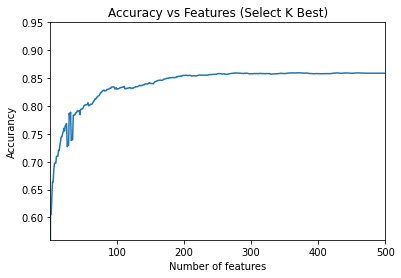

In [ ]:
acc_train = np.zeros(n_features)

for i in range(1,n_features):
    select = SelectKBest(k=i)
    X_train_i = select.fit_transform(X_train,y_train)
    X_test_i = select.transform(X_test)

    model = GaussianNB()
    model.fit(X_train_i, y_train)
    y_pred_i = model.predict(X_test_i)

    acc_train[i] = accuracy_score(y_pred_i,y_test)


plt.plot(acc_train)
axes = plt.gca()
axes.set_ylim([0.56,0.95])
axes.set_xlim([1,n_features])
plt.xlabel('Number of features',fontsize=10)
plt.ylabel('Accurancy')
plt.title("Accuracy vs Features (Select K Best)")

In [ ]:
#retrain on all train data
nb.fit(X, y)
y_unseen_pred = nb.predict(X_unseen)
y_unseen_pred = y_unseen_pred.astype(int)

#formatting
y_unseen_pred_df = pd.DataFrame(y_unseen_pred,columns=["Category"])
y_unseen_pred_df.index += 1

y_unseen_pred_df.to_csv("output.csv")

#files.download("output.csv")

In [ ]:
model = AdaBoostClassifier(GaussianNB(),n_estimators=50,learning_rate=0.35)
model.fit(X_train,y_train_minus)
y_pred_boost_nb = model.predict(X_test)

print("accuracy score", accuracy_score(y_pred_boost_nb,y_test_minus))


confusion_matrix = pd.crosstab(y_test_minus, 
                               y_pred_boost_nb, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)

plt.show()

accuracy score 0.8083518930957684


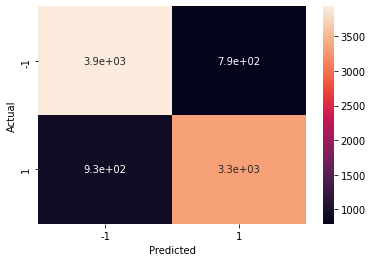

In [ ]:
model = AdaBoostClassifier(LogisticRegression(),n_estimators=50,learning_rate=0.35)
model.fit(X_train,y_train_minus)
y_pred_boost_logreg = model.predict(X_test)

print("accuracy score", accuracy_score(y_pred_boost_logreg,y_test_minus))


confusion_matrix = pd.crosstab(y_test_minus, 
                               y_pred_boost_logreg, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)

plt.show()

accuracy score 0.8661469933184855


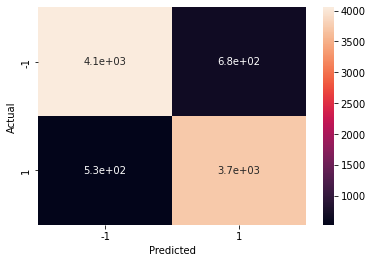

In [ ]:
model = AdaBoostClassifier(Perceptron(),n_estimators=50,learning_rate=0.33,algorithm="SAMME")
model.fit(X_train,y_train_minus)
y_pred_boost_perceptron = model.predict(X_test)

print("accuracy score", accuracy_score(y_pred_boost_perceptron,y_test_minus))


confusion_matrix = pd.crosstab(y_test_minus, 
                               y_pred_boost_perceptron, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

accuracy score 0.8537861915367483


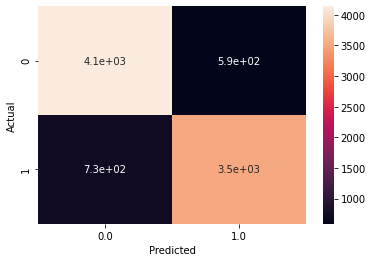

In [ ]:
y_pred_ensemble = np.ones(len(y_pred_boost_nb))

#majority vote
for i in range(len(y_pred_boost_nb)):
    if y_pred_boost_perceptron[i] + y_pred_boost_logreg[i] + y_pred_boost_nb[i] > 0: 
        y_pred_ensemble[i] = 1
    else:  y_pred_ensemble[i] = 0

print("accuracy score", accuracy_score(y_pred_ensemble,y_test))

confusion_matrix = pd.crosstab(y_test, 
                               y_pred_ensemble, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
#retrain on all train data
model = AdaBoostClassifier(GaussianNB(),n_estimators=50,learning_rate=0.35)
model.fit(X,y_minus)
y_pred_boost_nb = model.predict(X_unseen)

model = AdaBoostClassifier(LogisticRegression(),n_estimators=50,learning_rate=0.35)
model.fit(X,y_minus)
y_pred_boost_logreg = model.predict(X_unseen)

model = AdaBoostClassifier(Perceptron(),n_estimators=50,learning_rate=0.33,algorithm="SAMME")
model.fit(X,y_minus)
y_pred_boost_perceptron = model.predict(X_unseen)

y_pred_ensemble = np.zeros(len(y_pred_boost_nb))
#majority vote
for i in range(len(y_pred_boost_nb)):
    if y_pred_boost_perceptron[i] + y_pred_boost_logreg[i] + y_pred_boost_nb[i] > 0: 
        y_pred_ensemble[i] = 1
    else:  y_pred_ensemble[i] = 0


#formatting
y_unseen_pred_df = pd.DataFrame(y_pred_ensemble,columns=["Category"])
y_unseen_pred_df.index += 1
y_unseen_pred_df.index.name = "Id"

y_unseen_pred_df.to_csv("output.csv")
files.download("output.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#try this on the full data set
from sklearn.neural_network import MLPClassifier

m = MLPClassifier(solver="lbfgs", early_stopping=True)

for i in range(10):
    m.fit(X,y_minus)
    print(m.loss_)


0.0130546589312738
0.013070684931877094
0.013050424163032705
0.01305117220389493
0.013069711710629218
0.013098847639658927
0.013053701315729353
0.013043087173076248
0.013039849298703936
0.013068593952492458


In [ ]:

y_pred_mlp = m.predict(X_unseen)

y_pred_mlp = np.where(y_pred_mlp==1,1,0)

y_unseen_pred_df = pd.DataFrame(y_pred_mlp,columns=["Category"])
y_unseen_pred_df.index += 1
y_unseen_pred_df.index.name = "Id"

rows = [[22447,1], [22448,1], [22449,0]]
df_temp = pd.DataFrame(rows,columns =["Id","Category"])
df_temp.set_index("Id",inplace=True)

y_unseen_pred_df = y_unseen_pred_df.append(df_temp)
y_unseen_pred_df.to_csv("output.csv")
files.download("output.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

accuracy score 0.7855233853006681


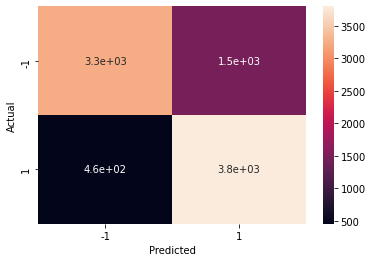

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(100)
model.fit(X_train,y_train_minus)
y_pred_boost_knn = model.predict(X_test)

print("accuracy score", accuracy_score(y_pred_boost_knn,y_test_minus))


confusion_matrix = pd.crosstab(y_test_minus, 
                               y_pred_boost_knn, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)

plt.show()

In [ ]:
#retrain on all train data
model = AdaBoostClassifier(GaussianNB(),n_estimators=50,learning_rate=0.35)
model.fit(X,y_minus)
y_pred_boost_nb = model.predict(X_unseen)

model = LinearSVC()
model.fit(X,y_minus)
y_pred_knn = model.predict(X_unseen)

model = AdaBoostClassifier(Perceptron(),n_estimators=50,learning_rate=0.33,algorithm="SAMME")
model.fit(X,y_minus)
y_pred_boost_perceptron = model.predict(X_unseen)

y_pred_ensemble = np.zeros(len(y_pred_boost_nb))

#majority vote
for i in range(len(y_pred_boost_nb)):
    if y_pred_boost_perceptron[i] + y_pred_knn[i] + y_pred_boost_nb[i] > 0: 
        y_pred_ensemble[i] = 1
    else:  y_pred_ensemble[i] = 0

#formatting
y_unseen_pred_df = pd.DataFrame(y_pred_ensemble,columns=["Category"])
y_unseen_pred_df.index += 1
y_unseen_pred_df.index.name = "Id"

rows = [[22447,int(1)], [22448,int(1)], [22449,int(1)]]
df_temp = pd.DataFrame(rows,columns =["Id","Category"])
df_temp.set_index("Id",inplace=True)

y_unseen_pred_df = y_unseen_pred_df.append(df_temp)
y_unseen_pred_df.Category = y_unseen_pred_df.Category.astype(int)

y_unseen_pred_df.to_csv("output.csv")
files.download("output.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_unseen_pred_df = pd.DataFrame(y_pred_ensemble,columns=["Category"])
y_unseen_pred_df.index += 1
y_unseen_pred_df.index.name = "Id"

rows = [[22447,int(1)], [22448,int(1)], [22449,int(1)]]
df_temp = pd.DataFrame(rows,columns =["Id","Category"])
df_temp.set_index("Id",inplace=True)

y_unseen_pred_df = y_unseen_pred_df.append(df_temp)
y_unseen_pred_df.Category = y_unseen_pred_df.Category.astype(int)

y_unseen_pred_df.to_csv("output.csv")
files.download("output.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

accuracy score 0.8942093541202673


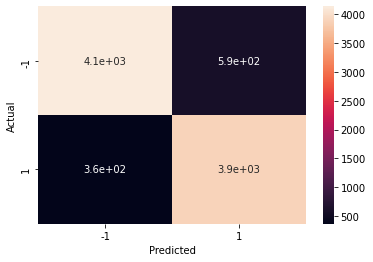

In [ ]:
# try svm 

from sklearn.svm import LinearSVC

model = LinearSVC()

model.fit(X_train,y_train_minus)

y_pred_svm = model.predict(X_test)

print("accuracy score", accuracy_score(y_pred_svm,y_test_minus))


confusion_matrix = pd.crosstab(y_test_minus, 
                               y_pred_svm, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)

plt.show()